In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin,clone

class Palanthir(object):
## Native attributes
    def __init__(self, input, target_feature:str=None, init_test_size:(float,None)=None):
        """Initiates a Palanthir-class on-top a Pandas Dataframe. The class-attributes describes the overall structure and composition of the data"""
        self.input_data = input
        ##When the Palanthir is born with a target variable:
        if isinstance(target_feature,str):
        #...AND is to be split into test-train subsets
            self.Y_col = [target_feature]
            self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
            if isinstance(init_test_size,float):
                self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.input_data[self.X_cols],self.input_data[self.Y_col],test_size=0.2,random_state=42)
                self.output = self.train_X#.copy(deep=True)
        #...BUT IS NOT to be split into test-train subsets
            else:
                self.Y = self.input_data.copy(deep=True)[self.Y_col]
                self.X = self.input_data.copy(deep=True)[self.X_cols]
                self.output = self.X#.copy(deep=True)
        ##When the Palanthir is NOT born with a target variable:
        else:
        # ...BUT IS to be split into test-train subsets
            if isinstance(init_test_size,float):
                self.train, self.test = train_test_split(self.input_data,test_size=0.2,random_state=42)
                self.output = self.train#.copy(deep=True)
        #...AND IS NOT to be split into test-train subsets.
            else:
                self.output = self.input_data.copy(deep=True)
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
        self.current_version = 0
        self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=Pipeline([]))]
        self.analysis_results = []
        #   With update_trans_historyV0 change above to this:     self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=ColumnTransformer([]))]


## Self-update and audit commands

    def update_attributes(self):
        self.size = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
    
    def update_trans_history(self, step=None, snapshot=None,transformer=None,cols=None):
        ## Get the current pipeline and its steps
        def restructure_ct(ct,transformer,cols):
            ## Get transformers from the CT-paramerets
            ct_steps = ct.get_params().get('transformers')
            ## Pair together columns and transformers from pipelines used in the ColumnTransformer
            trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
            ## Insert the new step from added transformer
            step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
            new_trans = ((step_order,transformer),cols)
            trans_col_pairs += [new_trans]
            ## Explode each transformer and each column for individual trans-on-col-pairs
            col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
            ## Collect to list all transformers on each column
            sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
            col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
            ## Collect to list all columns on each identical list of transformers
            sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
            ## Wrap transformers into pipeline and pipelines into ColumnTransformer
            new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
            ## Creates a new ColumnTransformer around the generated list of transformations
            list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
            new_ct = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
            return new_ct
        
        ## Get current pipeline and copy out a version to update    
        current_pipeline = self.transformation_history[-1].get('pipeline')
        new_pipeline = clone(current_pipeline)
        pipeline_steps = new_pipeline.steps
        no_of_steps = len(pipeline_steps)

        ## CASE A: For adding a new dataset-transformation:
        if cols is None:
            pipeline_steps.append((f'PL-{no_of_steps + 1}',transformer))
        ## CASE B: For adding a new feature-transformation:
        else:
            last_step = new_pipeline[-1] if no_of_steps > 0 else None
            last_step_type = last_step.__class__
            ## If last step IS a ColumnTransformer
            if last_step_type == type(ColumnTransformer([])):
                updated_ct = restructure_ct(ct=last_step,transformer=transformer,cols=cols)
                pipeline_steps.pop(-1)
                pipeline_steps.append((f'PL-{no_of_steps}',updated_ct))
            ## If last step IS NOT a ColumnTransformer
            else:
                updated_ct = restructure_ct(ct=ColumnTransformer([]),transformer=transformer,cols=cols)
                pipeline_steps.append((f'PL-{no_of_steps + 1}',updated_ct))
        
        ## Update the Transformation History-dictionary
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=new_pipeline
            )
        )

    def update_trans_historyFEATURETRANSFORMATIONSONLY(self, step=None, snapshot=None,transformer=None,cols=None):
        current_pipeline = self.transformation_history[-1].get('pipeline').get_params().get('transformers')
        ## Pair together columns and transformers from pipelines used in the ColumnTransformer
        trans_col_pairs = [(item,tup[2]) for tup in current_pipeline for item in tup[1].steps]
        ## Insert the new step from added transformer
        step_order = '1' if [step[0] for pip in current_pipeline for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in current_pipeline for step in pip[1].steps]) + 1)
        new_trans = ((step_order,transformer),cols)
        trans_col_pairs += [new_trans]
        ## Explode each transformer and each column for individual trans-on-col-pairs
        col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
        ## Collect to list all transformers on each column
        sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
        col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
        ## Collect to list all columns on each identical list of transformers
        sort_on_steps = sorted(col_trans_collect,key=lambda x: x[1])
        new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
        ## Wrap transformers into pipeline and pipelines into ColumnTransformer
        list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
        ## Update the Transformation History-dictionary
        updatedPipeline = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=updatedPipeline
            )
        )

    def update_analysis_results(self, model=None, perf_measure = None, scores=None, mean_score = None):
        self.analysis_results.append(
            dict(
                model = model,
                perf_measure = perf_measure ,
                scores = scores,
                mean_score = mean_score
            )
        )

    def restore(self, version=None):
        versionCheckpoint = (self.current_version - 1) if version == None else version
        self.current_version = versionCheckpoint
        self.output = self.transformation_history[versionCheckpoint].get('result')
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Restored to version {self.current_version}"
                ,result=self.transformation_history[self.current_version].get('result')
                ,pipeline=self.transformation_history[self.current_version].get('pipeline')
            )
        )
        return self.transformation_history[self.current_version].get('pipeline')

    def declare_target(self,target_feature:str):
        self.current_version += 1
        self.Y_col = [target_feature]
        self.X_cols = [col for col in self.input_data.columns if col not in self.Y_col]
        ## Palanthir has already been split into test-train subsets:
        if hasattr(self,'train') or hasattr(self,'test'):
            self.train_X = self.train[self.X_cols]
            self.train_Y = self.train[self.Y_col]
            self.test_X = self.test[self.X_cols]
            self.test_Y = self.test[self.Y_col]
            self.output = self.train_X#.copy(deep=True)
            del self.train, self.test
        ## Palanthir has NOT already been split into test-train subsets:
        else:
            self.Y = self.input_data.copy(deep=True)[self.Y_col]
            self.X = self.input_data.copy(deep=True)[self.X_cols]
            self.output = self.X#.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into X and Y"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self #self.Y_col

    def random_split(self, test_size=0.2):
        """Uses the SKLearn Train_Test_Split to divide the dataset into random training and test subset"""
        from sklearn.model_selection import train_test_split
        self.current_version += 1
        ## Palanthir is already split into X-Y features:
        if hasattr(self,'Y') or hasattr(self,'X'):
            self.train_X, self.test_X, self.train_Y, self.test_Y = train_test_split(self.X,self.Y,test_size=test_size,random_state=42)
            self.output = self.train_X.copy(deep=True)
        ## Palanthir is NOT already split into X-Y features:
        else:
            self.train, self.test = train_test_split(self.input_data,test_size=test_size,random_state=42)
            self.output = self.train.copy(deep=True)
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Split into Test and Train"
                ,result=self.output
                ,pipeline=self.transformation_history[self.current_version-1].get('pipeline'))
        )
        return self.output

## Summarization and description commands
    def summarize(self):
        """Prints the info, description and any missing value-counts for the class"""
        dataset = self.output
        return print(
            "Info: ", dataset.info(),
            "\n",
            "Description: ", dataset.describe(),
            "\n",
            "Missing values: ", dataset.isna().sum()

        )

## Data preprocessing commands

    ## TO BE DEVELOPED
    def stratified_split(self, cols, store=True):
        """Uses the SKLearn StratigiesShuffleSplit to divide the dataset into stratified training and test subset"""
        from sklearn.model_selection import StratifiedShuffleSplit
        dataset = self.output
        split = StratifiedShuffleSplit(n_split=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(dataset, dataset[cols]):
            strat_train_set = dataset.loc[train_index]
            strat_test_set = dataset.loc[test_index]
        if store:
            self.train_subset, self.test_subset = [strat_train_set], [strat_test_set]
        return strat_train_set, strat_test_set

    def execute_pipeline(self, dataset=None, pipeline_version=None):
        """Uses the SKLearn ColumnTransformer build via previous transformations and apply its transformations to the target dataset"""
        versionCheckpoint = self.current_version if pipeline_version == None else pipeline_version
        pipeline = self.transformation_history[versionCheckpoint].get('pipeline')
        ## Check if a dataset is given at function-runtime
        if isinstance(dataset,pd.core.frame.DataFrame):
            dataset = dataset
            fitted_pipeline = pipeline.fit(self.input_data)
        ## Alternatively check if the Palanthir has already got a X-Y split in its test-train subsets:
        else:
            dataset = self.test_X if hasattr(self,'test_X') else self.test
            fitted_pipeline = pipeline.fit(self.train_X) if hasattr(self,'train_X') else pipeline.fit(self.test)
        self.transformed_test = fitted_pipeline.set_output(transform='pandas').transform(dataset)
        return self

## Feature Engineering commands

    def fill_nulls(self, strategy="median", include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn SimpleImputer to fill out any missing values in the numerical features of the dataset"""
        from sklearn.impute import SimpleImputer
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        transformer = SimpleImputer(strategy=strategy)
        fitted_transformer = transformer.fit(dataset).set_output(transform='pandas')
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            self.output[columns] = transformed_data
            self.update_attributes()
            self.update_trans_history(step="Filled nulls",snapshot=self.output,transformer=transformer,cols=columns)
        return self

    def encode_order(self, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn OrdinalEncoder to order any categorical features of the dataset"""
        from sklearn.preprocessing import OrdinalEncoder
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        transformer = OrdinalEncoder()
        fitted_transformer = transformer.fit(dataset).set_output(transform='pandas')
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            self.output[columns] = transformed_data
            self.update_attributes()
            self.update_trans_history(step="Encoded order of categorial features",snapshot=self.output,transformer=transformer,cols=columns)
        return self
    
    def make_dummies(self, include_features = [], exclude_features=[], store=True):
        """Uses a customized version of the SKLearn OneHotEncoder to turn categorical features of the dataset into dummy-variables"""
        ## Create Custom Transformer for applying OneHotCoding-columns
        from sklearn.preprocessing import OneHotEncoder
        from sklearn.base import BaseEstimator,TransformerMixin
        from sklearn.utils import check_random_state
        class OneHotter(BaseEstimator,TransformerMixin):
            def __init__(self, random_state=None):
                self.random_state = random_state

            def fit(self, X, y=None):
                self.random_state_ = check_random_state(self.random_state)
                self.estimator = OneHotEncoder().fit(X)
                self.new_col_names = self.estimator.get_feature_names_out
                return self

            def transform(self, X, y=None):
                X_trans = self.estimator.transform(X).toarray()
                X_trans_df = pd.DataFrame(data=X_trans, columns=self.new_col_names(), index=X.index)
                return X_trans_df

            def get_feature_names_out(self):
                pass
        
        columns = [col for col in self.features_cat if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        remain_columns = [col for col in self.output.columns if col not in columns]
        dataset = self.output[columns]
        transformer = OneHotter()
        fitted_transformer = transformer.fit(dataset)
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            staged_output = self.output.copy()
            self.output = pd.merge(staged_output[remain_columns], transformed_data, left_index=True, right_index=True)
            self.update_attributes()
            self.update_trans_history(step="Turned categorical features into dummy variables",snapshot=self.output,transformer=transformer,cols=columns)
        return self

    def scale(self, strategy:str, include_features = [], exclude_features=[], store=True):
        """Uses the SKLearn StandardScaler or MinMaxScaler to scale all numerical features of the dataset"""
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        if strategy=="Standard":
            transformer = StandardScaler()
        elif strategy=="MinMax":
            transformer = MinMaxScaler()
        else:
            print('Not a proper scaler')
        fitted_transformer = transformer.fit(dataset).set_output(transform='pandas')
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            self.output[columns] = transformed_data
            self.update_attributes()
            self.update_trans_history(step=f"""Scaled feature-values using {'Standard-scaler' if strategy=='Standard' else 'MinMax-scaler'}""",snapshot=self.output,transformer=transformer,cols=columns)
        return self
    
    def remove_outliers(self, include_features = [], exclude_features = [], factor=1.5, store=True):
        from sklearn.base import BaseEstimator,TransformerMixin
        class OutlierRemover(BaseEstimator,TransformerMixin):
            def __init__(self,factor=factor):
                self.factor = factor

            def outlier_detector(self,X,y=None):
                X = pd.Series(X).copy()
                q1 = X.quantile(0.25)
                q3 = X.quantile(0.75)
                iqr = q3 - q1
                self.lower_bound.append(q1 - (self.factor * iqr))
                self.upper_bound.append(q3 + (self.factor * iqr))

            def fit(self,X,y=None):
                self.lower_bound = []
                self.upper_bound = []
                X.apply(self.outlier_detector)
                return self

            def transform(self,X,y=None):
                X = pd.DataFrame(X).copy()
                for i in range(X.shape[1]):
                    x = X.iloc[:, i].copy()
                    x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
                    X.iloc[:, i] = x
                return X
            
            def get_feature_names_out(self):
                pass
            
        columns = [col for col in self.features_num if col not in exclude_features] if include_features == [] else [col for col in include_features if col not in exclude_features]
        dataset = self.output[columns]
        transformer = OutlierRemover()
        fitted_transformer = transformer.fit(dataset)
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            self.output[columns] = transformed_data
            self.update_attributes()
            self.update_trans_history(step="Removed Outliers",snapshot=self.output,transformer=transformer,cols=columns)
        return self
    
## Dataset Engineering commands (to be developed)
    
    def PCA(self, n_components=0.80, store=True):
        from sklearn.decomposition import PCA
        dataset = self.output
        transformer = PCA(n_components=n_components).fit(dataset)
        pca_data = transformer.transform(dataset)
        output_df = pd.DataFrame(pca_data, columns=["PCA_" + str(col + 1) for col in range(pca_data.shape[1])],index=dataset.index)
        if store:
            self.output = output_df
            self.update_attributes()
            self.update_trans_history(step="Performed Principal Component Analysis",snapshot=self.output,transformer=transformer,cols=None)
        explained_variance = PCA().fit(dataset).explained_variance_ratio_
        cumsum = np.cumsum(explained_variance)
        print(cumsum)
        plt.plot(["PCA" + str(num) for num in range(1, len(cumsum) + 1)], cumsum)
        plt.show()
        return self

    def cluster(self, max_k=10, store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        from sklearn.base import BaseEstimator,TransformerMixin
        from sklearn.cluster import KMeans
        from sklearn.utils import check_random_state
        from sklearn.metrics import silhouette_score
        from matplotlib import pyplot

        ## Create Custom Transformer for updating Cluster-label column
        class ClusterIdentifier(BaseEstimator,TransformerMixin):
            def __init__(self, Ks,random_state=None):
                self.random_state = random_state
                self.Ks = Ks

            def fit(self, X, y=None):
                self.random_state_ = check_random_state(self.random_state)
                self.estimator = KMeans(n_clusters=self.Ks, n_init='auto', random_state=42).fit(X)
                return self

            def transform(self, X, y=None):
                X_trans = self.estimator.predict(X)
                X['cluster'] = X_trans
                return X

            def get_feature_names_out(self):
                pass

        dataset = self.output
        kmeans_per_k = [KMeans(n_clusters=k, n_init='auto', random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        transformer = ClusterIdentifier(Ks=best_k)
        fitted_transformer = transformer.fit(dataset)
        transformed_data = fitted_transformer.transform(dataset)
        if store:
            staged_output = self.output.copy()
            self.output = transformed_data #pd.merge(staged_output[remain_columns], transformed_data, left_index=True, right_index=True)
            self.update_attributes()
            self.update_trans_history(step="Added Cluster-label as column to dataset",snapshot=self.output,transformer=transformer,cols=None)
        return self

## Analysis commands
    def kfold_cross_validate(self, model, x, y, score_measure="neg_mean_squared_error", cv=10):
        """Uses the SKLearn Cross_Val_Score to cross-validate one/several models on the training subset"""
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, X=x, y=y, scoring=score_measure, cv=cv)
        return scores
    
    def analyze(self, model, x=None, y=None, score_measure="neg_mean_squared_error", cv_folds=10):
        """Run various analysis using the kfold-cros-validation-technique"""
        X = self.train_X if x is None else x
        Y = self.train_Y if y is None else y
        models = [item.fit(X,Y) for item in model] if isinstance(model,list) else [model]
        scores = [self.kfold_cross_validate(model=model,x=X,y=Y,score_measure=score_measure,cv=cv_folds) for model in models]
        mean_scores = [np.mean(i) for i in scores]
        #scores = [{'model': model, 'scores': self.kfold_cross_validate(model=model,x=X,y=Y,score_measure=score_measure,cv=cv_folds)} for model in models]
        for m,s,ms in zip(models,scores,mean_scores):
            self.update_analysis_results(model=m,perf_measure=score_measure,scores=s,mean_score=ms)
        return self.analysis_results

    def full_analysis(self, model):
        """Conducts a full data-analysis pipeline on the dataset, including model training, evaluation and tuning"""
        dataset = self.output
        X_train, X_test, Y_train, Y_test = self.random_split(dataset)

        sqrt_scores = np.sqrt(-self.cross_validate(model, X_train, Y_train, score_measure="neg_mean_squared_error", folds=10))
        print(
            "RMSE-scores: ", sqrt_scores,
            "RMSE-mean: ", sqrt_scores.mean(),
            "RMSE-std: ", sqrt_scores.std()
        )

# **Declare the Palanthir-object on the input dataframe**

In [132]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)

In [133]:
pal = Palanthir(df,
                #target_feature='ocean_proximity',
                init_test_size=0.2
)

# **Exploration**

In [134]:
pal.summarize()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB
Info:  None 
 Description:            longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean    -119.582290     35.643149           28.608285   2642.004784   
std   

# **Data Transformation**

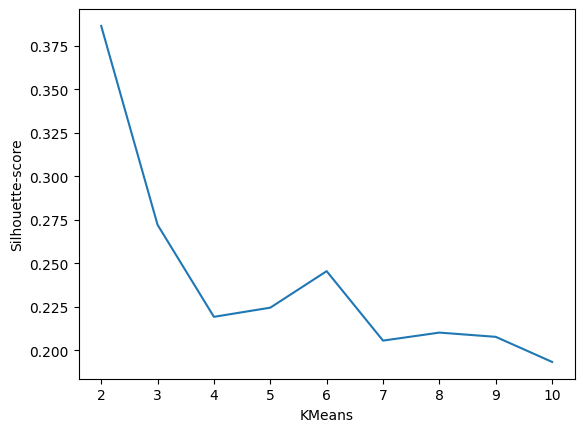

Best silhouette is obtained with k as:  2


In [135]:
pal.remove_outliers().fill_nulls(exclude_features=['longitude','latitude']).scale(strategy="Standard",exclude_features=['longitude','latitude']).encode_order().cluster()

In [118]:
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster
14196,-117.03,32.71,0.348490,0.815058,0.746017,1.730436,0.905437,-0.275143,-0.936434,4.0,0
8267,-118.16,33.77,1.618118,1.044479,1.443823,0.147864,1.524036,0.099309,2.066956,4.0,0
17445,-120.48,34.66,-1.952710,-0.286344,-0.544926,-0.492548,-0.429434,0.332148,-0.187470,4.0,0
14265,-117.11,32.69,0.586545,-0.712925,-0.387919,0.314788,-0.341063,-1.167152,-1.039739,4.0,0
2271,-119.80,36.78,1.142008,0.148302,-0.108796,-0.558355,-0.224785,-0.075625,-1.006380,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,0.507194,-0.794477,-1.111893,-0.905044,-0.982918,1.831381,0.421602,0.0,0
11964,-117.43,34.02,0.348490,0.777418,0.497423,0.852477,0.096142,-0.417095,-0.992391,1.0,0
5390,-118.38,34.03,0.586545,-0.103524,0.493062,0.857292,0.458929,-0.495386,0.345199,0.0,0
860,-121.96,37.58,-1.079841,1.217442,0.615178,0.890998,0.607765,1.390625,1.005923,0.0,1


In [72]:
pal.remove_outliers().fill_nulls().scale(strategy="MinMax",exclude_features=['longitude','latitude'])

[0.92287071 0.9637602  0.9791724  0.98597206 0.99065132 0.99370639
 0.99573555 0.99735813 0.99874044 0.99973346 1.        ]


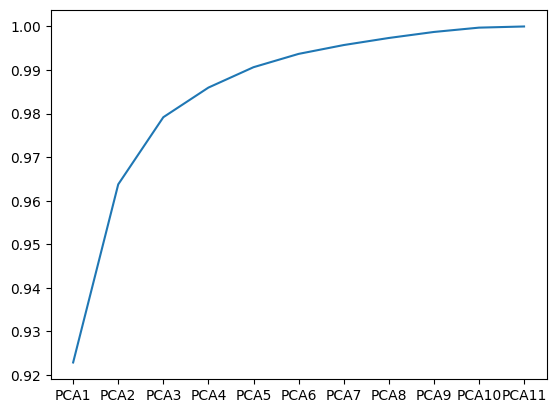

In [73]:
pal.PCA()

In [74]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=[('PL-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CT-0',
                                                  Pipeline(steps=[('1',
                                                                   OutlierRemover()),
                                                                  ('2',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('3',
                                                                   StandardScaler())]),
                                                  ['households',
                                                   'housing_median_age',
                                                   'median_house_value',
                                                   'median_income',
                                                   'population',
                                                   'total_bedrooms',
                                                   'total_rooms']),
                                                 ('CT-1',
                                                  Pipeline(steps=[('1',
                                                                   OutlierRemov...
                                                                  ('3',
                                                                   MinMaxScaler())]),
                                                  ['cluster', 'households',
                                                   'housing_median_age',
                                                   'median_house_value',
                                                   'median_income',
                                                   'ocean_proximity',
                                                   'population',
                                                   'total_bedrooms',
                                                   'total_rooms']),
                                                 ('CT-1',
                                                  Pipeline(steps=[('1',
                                                                   OutlierRemover()),
                                                                  ('2',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['latitude', 'longitude'])],
                                   verbose_feature_names_out=False)),
                ('PL-4', PCA(n_components=0.8))])

In [75]:
pal.restore(version=5)
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=[('PL-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('CT-0',
                                                  Pipeline(steps=[('1',
                                                                   OutlierRemover()),
                                                                  ('2',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('3',
                                                                   StandardScaler())]),
                                                  ['households',
                                                   'housing_median_age',
                                                   'median_house_value',
                                                   'median_income',
                                                   'population',
                                                   'total_bedrooms',
                                                   'total_rooms']),
                                                 ('CT-1',
                                                  Pipeline(steps=[('1',
                                                                   OutlierRemover())]),
                                                  ['latitude', 'longitude']),
                                                 ('CT-2',
                                                  Pipeline(steps=[('4',
                                                                   OrdinalEncoder())]),
                                                  ['ocean_proximity'])],
                                   verbose_feature_names_out=False)),
                ('PL-2', ClusterIdentifier(Ks=2))])

# **Analysis**

In [136]:
pal.declare_target('ocean_proximity')

In [129]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
m_linReg = LinearRegression()
m_Tree = DecisionTreeRegressor()
models = [m_linReg, m_Tree]

In [137]:
pal.analyze(models)

[{'model': LinearRegression(),
  'perf_measure': 'neg_mean_squared_error',
  'scores': array([-1.87155268, -1.78497603, -1.72212758, -1.71276541, -1.80191621,
         -1.71833168, -1.7120546 , -1.70293028, -1.68944295, -1.71047842]),
  'mean_score': -1.7426575844531338},
 {'model': DecisionTreeRegressor(),
  'perf_measure': 'neg_mean_squared_error',
  'scores': array([-0.2433414 , -0.27421308, -0.18776499, -0.21865536, -0.28528165,
         -0.20169594, -0.3367656 , -0.22289522, -0.31314355, -0.24409449]),
  'mean_score': -0.25278512692432353}]

In [122]:
pal.analysis_results[-1]

{'model': DecisionTreeRegressor(),
 'perf_measure': 'neg_mean_squared_error',
 'scores': array([-0.28510896, -0.3062954 , -0.14900061, -0.24227741, -0.26287099,
        -0.22107813, -0.31496063, -0.21804967, -0.31556632, -0.24046033]),
 'mean_score': -0.9991122142629582}

# **Validate on Test**

In [21]:
pal.execute_pipeline()

c:\Users\JesperFrederiksen\PycharmProjects\ML-code\venv\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [22]:
pal.transformed_test

,households,housing_median_age,median_house_value,median_income,population,total_bedrooms,total_rooms,latitude,longitude,ocean_proximity,cluster
20046,-0.306124,-0.300740,-1.520980,-1.352218,0.284833,-0.170782,-0.615699,36.06,-119.01,1.0,1
3024,0.748321,0.098724,-1.541359,-0.750792,0.562359,-0.170782,0.677186,35.14,-119.46,1.0,1
15663,2.524476,1.856363,-0.188799,-0.079538,0.153289,-0.170782,1.474675,37.80,-122.44,3.0,0
20484,0.331230,-0.939881,0.312110,1.517592,0.786947,-0.170782,0.774287,34.28,-118.72,0.0,1
9814,0.017239,0.418295,0.949240,0.093724,-0.242947,-0.170782,0.144927,36.62,-121.93,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...
15362,0.129713,-1.019774,0.791566,0.716303,0.219061,0.143312,0.876783,33.36,-117.22,0.0,1
16623,1.315378,-0.061061,0.829107,-0.612622,0.698716,1.956082,1.917924,35.36,-120.83,4.0,0
18086,0.673338,-0.300740,-0.188799,-0.123790,0.594443,0.394587,1.727318,37.31,-122.05,0.0,0
2144,0.232815,0.578080,-1.257118,-0.571305,0.020141,0.071519,0.285184,36.77,-119.76,1.0,0


In [23]:
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster
14196,-117.03,32.71,0.627451,0.639378,0.624128,0.845729,0.662407,0.390091,0.214951,0.0,0.0
8267,-118.16,33.77,0.941176,0.691772,0.783649,0.482695,0.804047,0.468245,0.896678,0.0,0.0
17445,-120.48,34.66,0.058824,0.387843,0.329013,0.335788,0.356763,0.516842,0.384955,0.0,0.0
14265,-117.11,32.69,0.686275,0.290422,0.364905,0.520987,0.376997,0.203915,0.191502,0.0,0.0
2271,-119.80,36.78,0.823529,0.487106,0.428714,0.320692,0.403621,0.431734,0.199074,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,0.666667,0.271797,0.199402,0.241163,0.230032,0.829755,0.523206,0.0,0.0
11964,-117.43,34.02,0.627451,0.630782,0.567298,0.644330,0.477103,0.360464,0.202249,0.5,0.0
5390,-118.38,34.03,0.686275,0.429595,0.566301,0.645434,0.560170,0.344123,0.505863,0.0,0.0
860,-121.96,37.58,0.274510,0.731273,0.594217,0.653166,0.594249,0.737762,0.655839,0.0,1.0


____

Original

In [109]:
orig_pipeline = pal.transformation_history[-1].get('pipeline')
orig_pipeline
ct_steps = orig_pipeline.get_params().get('transformers')
ct_steps
transformer = StandardScaler()
cols = ['longitude','latitude']
#restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)

trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
trans_col_pairs
step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
step_order
new_trans = ((step_order,transformer),cols)
new_trans
trans_col_pairs += [new_trans]
trans_col_pairs
col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
col_trans_explode
sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
sort_on_cols
col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
col_trans_collect

sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
sort_on_steps

new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
new_trans_col_pairs

list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
new_ct_old = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
new_ct_old

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', StandardScaler())]),
                                 ['latitude', 'longitude'])],
                  verbose_feature_names_out=False)

New

In [108]:
orig_pipeline = pal2.transformation_history[-1].get('pipeline')[-1]
orig_pipeline
ct_steps = orig_pipeline.get_params().get('transformers')
ct_steps
transformer = StandardScaler()
cols = ['longitude','latitude']
#restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)

trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
trans_col_pairs
step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
step_order
new_trans = ((step_order,transformer),cols)
new_trans
trans_col_pairs += [new_trans]
trans_col_pairs
col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
col_trans_explode
sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
sort_on_cols
col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
col_trans_collect

sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
sort_on_steps

new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
new_trans_col_pairs

list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
new_ct_new = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
new_ct_new

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', StandardScaler())]),
                                 ['latitude', 'longitude'])],
                  verbose_feature_names_out=False)

__Hentet funktionsdefinitionen fra cellerne ovenfor__

In [216]:
#current_pipeline = pal.transformation_history[-1].get('pipeline')
current_pipeline = pal2.transformation_history[-1].get('pipeline')
current_pipeline
new_pipeline = clone(current_pipeline)
#pipeline_steps = new_pipeline.steps
#no_of_steps = len(pipeline_steps)

last_step = new_pipeline[-1] if no_of_steps > 0 else None
last_step
last_step_type = last_step.__class__
last_step_type == type(ColumnTransformer([]))

transformer = OrdinalEncoder()
cols = ['ocean_proximity']

ct_steps = last_step.get_params().get('transformers')
ct_steps
trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
trans_col_pairs
step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
step_order
new_trans = ((step_order,transformer),cols)
new_trans
trans_col_pairs += [new_trans]
trans_col_pairs
col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
col_trans_explode
sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
sort_on_cols
col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
col_trans_collect
#
sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
sort_on_steps
#
new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
new_trans_col_pairs
#
list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
new_ct = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
new_ct 
#pipeline_steps.pop(-1)
#pipeline_steps.append((f'PL-{no_of_steps}',updated_ct))
#pipeline_steps

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['latitude', 'longitude']),
                                ('CT-2',
                                 Pipeline(steps=[('3', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

Original update

In [91]:
orig_pipeline = new_ct_old
orig_pipeline
ct_steps = orig_pipeline.get_params().get('transformers')
ct_steps
transformer = OrdinalEncoder()
cols = ['ocean_proximity']
#restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)

trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
trans_col_pairs
step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
step_order
new_trans = ((step_order,transformer),cols)
new_trans
trans_col_pairs += [new_trans]
trans_col_pairs
col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
col_trans_explode
sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
sort_on_cols
col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
col_trans_collect

sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
sort_on_steps

new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
new_trans_col_pairs

list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
new_ct_old = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
new_ct_old

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2',
                                 Pipeline(steps=[('3', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

New Update

In [92]:
orig_pipeline = new_ct_new
orig_pipeline
ct_steps = orig_pipeline.get_params().get('transformers')
ct_steps
transformer = OrdinalEncoder()
cols = ['ocean_proximity']
#restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)

trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
trans_col_pairs
step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
step_order
new_trans = ((step_order,transformer),cols)
new_trans
trans_col_pairs += [new_trans]
trans_col_pairs
col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
col_trans_explode
sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
sort_on_cols
col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
col_trans_collect

sort_on_steps = sorted(col_trans_collect,key=lambda l : str(l[1]))
sort_on_steps

new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
new_trans_col_pairs

list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
new_ct_new = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
new_ct_new

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2',
                                 Pipeline(steps=[('3', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

______

In [143]:
def restructure_ct(ct_steps,transformer,cols):
    ## Pair together columns and transformers from pipelines used in the ColumnTransformer
    trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
    ## Insert the new step from added transformer    
    step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
    new_trans = ((step_order,transformer),cols)
    trans_col_pairs += [new_trans]
    ## Explode each transformer and each column for individual trans-on-col-pairs
    col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
    ## Collect to list all transformers on each column
    sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
    col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
    ## Collect to list all columns on each identical list of transformers
    sort_on_steps = sorted(col_trans_collect,key=lambda x: x[1])
    new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
    ## Wrap transformers into pipeline and pipelines into ColumnTransformer
    list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
    ## Creates a new ColumnTransformer around the generated list of transformations
    new_ct = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
    return new_ct

#restructure_ct(ct_steps=ct_steps_orig,transformer=transformer,cols=cols) == restructure_ct(ct_steps=ct_steps_new,transformer=transformer,cols=cols)

In [435]:
ct_steps_orig = pal.transformation_history[-1].get('pipeline').get_params().get('transformers')
ct_steps_new = pal2.transformation_history[-1].get('pipeline')[-1].get_params().get('transformers')

transformer = StandardScaler()
cols = ['longitude','latitude']

V1old = restructure_ct(ct_steps=ct_steps_orig,transformer=transformer,cols=cols)
V1old

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude'])],
                  verbose_feature_names_out=False)

In [436]:
V1new = restructure_ct(ct_steps=ct_steps_new,transformer=transformer,cols=cols)
V1new

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude'])],
                  verbose_feature_names_out=False)

In [389]:
ct_steps_orig = V1old.get_params().get('transformers')
ct_steps_new = V1new.get_params().get('transformers')

transformer = SimpleImputer()
cols = ['households', 'housing_median_age', 'median_house_value', 'median_income', 'population', 'total_bedrooms', 'total_rooms']

V2old = restructure_ct(ct_steps=ct_steps_orig,transformer=transformer,cols=cols)
V2old

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', SimpleImputer())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms'])],
                  verbose_feature_names_out=False)

In [390]:
V2new = restructure_ct(ct_steps=ct_steps_new,transformer=transformer,cols=cols)
V2new

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', SimpleImputer())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms'])],
                  verbose_feature_names_out=False)

In [391]:
ct_steps_orig = V2old.get_params().get('transformers')
ct_steps_new = V2new.get_params().get('transformers')

transformer = OrdinalEncoder()
cols = ['ocean_proximity']

In [392]:
V3old = restructure_ct(ct_steps=ct_steps_orig,transformer=transformer,cols=cols)
V3old

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', SimpleImputer())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2',
                                 Pipeline(steps=[('4', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

In [393]:
V3new = restructure_ct(ct_steps=ct_steps_new,transformer=transformer,cols=cols)
V3new

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', StandardScaler())]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('3', SimpleImputer())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2',
                                 Pipeline(steps=[('4', OrdinalEncoder())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

___

In [383]:
def update_history(self, step=None, snapshot=None,transformer=None,cols=None):
        ## Get the current pipeline and its steps
        def restructure_ct(ct_steps,transformer,cols):
            ## Pair together columns and transformers from pipelines used in the ColumnTransformer
            trans_col_pairs = [(item,tup[2]) for tup in ct_steps for item in tup[1].steps]
            ## Insert the new step from added transformer    
            step_order = '1' if [step[0] for pip in ct_steps for step in pip[1].steps] == [] else str(max([int(step[0]) for pip in ct_steps for step in pip[1].steps]) + 1)
            new_trans = ((step_order,transformer),cols)
            trans_col_pairs += [new_trans]
            ## Explode each transformer and each column for individual trans-on-col-pairs
            col_trans_explode = [(tup[0],col) for tup in trans_col_pairs for col in tup[1]]
            ## Collect to list all transformers on each column
            sort_on_cols = sorted(col_trans_explode,key=lambda l:l[1])
            col_trans_collect = [(key,list(item[0] for item in group)) for key, group in itertools.groupby(sort_on_cols, key=lambda x: x[1])]
            ## Collect to list all columns on each identical list of transformers
            sort_on_steps = sorted(col_trans_collect,key=lambda x: x[1])
            new_trans_col_pairs = [{'columns':list(item[0] for item in group),'transformers':key} for key,group in itertools.groupby(sort_on_steps,key=lambda x: x[1])]
            ## Wrap transformers into pipeline and pipelines into ColumnTransformer
            list_of_params = [(f'CT-{index}',Pipeline(value.get('transformers')),value.get('columns')) for index,value in enumerate(new_trans_col_pairs)]
            ## Creates a new ColumnTransformer around the generated list of transformations
            new_ct = ColumnTransformer(list_of_params,remainder='passthrough',verbose_feature_names_out=False)
            return new_ct
        
        ## Get current pipeline and copy out a version to update    
        current_pipeline = self.transformation_history[-1].get('pipeline')
        new_pipeline = clone(current_pipeline)
        pipeline_steps = new_pipeline.steps
        no_of_steps = len(pipeline_steps)

        ## CASE A: For adding a new dataset-transformation:
        if cols is None:
            pipeline_steps.append((f'PL-{no_of_steps + 1}',transformer))
        ## CASE B: For adding a new feature-transformation:
        else:
            last_transformer = pipeline_steps[-1][1] if no_of_steps > 0 else None
            last_transformer_type = last_transformer.__class__
            ## If last step IS a ColumnTransformer
            if last_transformer_type == type(ColumnTransformer([])):
                ct_steps = last_transformer.get_params().get('transformers')
                updated_ct = restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)
                pipeline_steps.pop(-1)
                pipeline_steps.append((f'PL-{no_of_steps}',updated_ct))
            ## If last step IS NOT a ColumnTransformer
            else:
                ct_steps = []
                updated_ct = restructure_ct(ct_steps=ct_steps,transformer=transformer,cols=cols)
                pipeline_steps.append((f'PL-{no_of_steps + 1}',updated_ct))
        
        ## Update the Transformation History-dictionary
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=new_pipeline
            )
        )

In [582]:
pal.fill_nulls()

In [583]:
pal.scale(strategy='Standard',exclude_features=['longitude','latitude'])

In [584]:
pal.make_dummies()

In [399]:
pal.encode_order()

____

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
test_model1 = LinearRegression()
test_model2 = DecisionTreeRegressor()
test_models = [test_model1,test_model2]

In [116]:
pal.remove_outliers().fill_nulls().scale("MinMax").encode_order().declare_target('median_income').analyze(model=test_models,x=pal.train_X,y=pal.train_Y,cv_folds=10)

[{'model': LinearRegression(),
  'scores': array([-0.02305096, -0.02052612, -0.02153709, -0.02016055, -0.02202744,
         -0.02135826, -0.0202138 , -0.02102566, -0.02086841, -0.02419331])},
 {'model': DecisionTreeRegressor(),
  'scores': array([-0.02584173, -0.02755259, -0.02846396, -0.02739184, -0.02712636,
         -0.02674824, -0.0254654 , -0.02566398, -0.02709474, -0.02897765])}]

In [117]:
pal.output == pal.train

AttributeError: 'Palanthir' object has no attribute 'train'

In [229]:
pal.test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,-117.22,33.36,16.0,3165.0,482.0,1351.0,452.0,4.6050,263300.0,<1H OCEAN
16623,-120.83,35.36,28.0,4323.0,886.0,1650.0,705.0,2.7266,266800.0,NEAR OCEAN
18086,-122.05,37.31,25.0,4111.0,538.0,1585.0,568.0,9.2298,500001.0,<1H OCEAN
2144,-119.76,36.77,36.0,2507.0,466.0,1227.0,474.0,2.7850,72300.0,INLAND


In [232]:
pal.execute_pipeline().transformed_test

,households,housing_median_age,latitude,longitude,median_house_value,median_income,population,total_bedrooms,total_rooms,ocean_proximity
20046,0.332093,0.470588,0.379720,0.539022,0.070766,0.162233,0.443022,0.353144,0.267201,1.0
3024,0.541395,0.568627,0.280475,0.492196,0.066654,0.278981,0.498399,0.353144,0.523529,1.0
15663,0.893953,1.000000,0.567422,0.182102,0.339538,0.409284,0.416773,0.353144,0.681640,3.0
20484,0.458605,0.313725,0.187702,0.569199,0.440598,0.719316,0.543214,0.353144,0.542781,0.0
9814,0.396279,0.647059,0.440129,0.235172,0.569142,0.442917,0.337708,0.353144,0.418004,4.0
...,...,...,...,...,...,...,...,...,...,...
15362,0.418605,0.294118,0.088457,0.725286,0.537331,0.563771,0.429898,0.413437,0.563102,0.0
16623,0.653953,0.529412,0.304207,0.349636,0.544905,0.305802,0.525608,0.761413,0.769519,4.0
18086,0.526512,0.470588,0.514563,0.222685,0.339538,0.400694,0.504802,0.461671,0.731729,0.0
2144,0.439070,0.686275,0.456311,0.460978,0.124001,0.313823,0.390205,0.399655,0.445811,1.0


In [223]:
pal.remove_outliers().fill_nulls(strategy="median").scale(strategy="MinMax").encode_order().declare_target('median_income')
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,ocean_proximity
14196,0.729084,0.017021,0.627451,0.546823,0.534586,0.734335,0.569076,0.187996,4.0
8267,0.616534,0.129787,0.941176,0.591633,0.671221,0.419118,0.690759,0.784235,4.0
17445,0.385458,0.224468,0.058824,0.331700,0.281810,0.291560,0.306496,0.336682,4.0
14265,0.721116,0.014894,0.686275,0.248381,0.312553,0.452366,0.323879,0.167487,4.0
2271,0.453187,0.450000,0.823529,0.416594,0.367208,0.278453,0.346752,0.174110,1.0
...,...,...,...,...,...,...,...,...,...
11284,0.636454,0.130851,0.666667,0.232452,0.170794,0.209399,0.197621,0.457596,0.0
11964,0.689243,0.156383,0.627451,0.539471,0.485909,0.559463,0.409881,0.176887,1.0
5390,0.594622,0.157447,0.686275,0.367408,0.485056,0.560422,0.481244,0.442428,0.0
860,0.238048,0.535106,0.274510,0.625416,0.508967,0.567136,0.510522,0.573596,0.0


In [159]:
pal.train_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,96500.0,INLAND
...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,229200.0,<1H OCEAN
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,97800.0,INLAND
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,222100.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,283500.0,<1H OCEAN


In [146]:
from sklearn.linear_model import LinearRegression
test_model = LinearRegression()

X = pal.output[pal.X_cols]
Y = pal.output[pal.Y_col]
test_model.fit(x=X,y=Y)
#test_mode.predict(x=X,y=Y)
#pal.analyze(model=test_model)

KeyError: "None of [Index(['median_income'], dtype='object')] are in the [columns]"

In [133]:
pal.execute_pipeline().transformed_test

,households,housing_median_age,latitude,longitude,median_house_value,median_income,population,total_bedrooms,total_rooms,ocean_proximity
20046,359.0,25.0,36.06,-119.01,47700.0,1.6812,1392.0,NaN,1505.0,INLAND
3024,584.0,30.0,35.14,-119.46,45800.0,2.5313,1565.0,NaN,2943.0,INLAND
15663,963.0,52.0,37.80,-122.44,NaN,3.4801,1310.0,NaN,3830.0,NEAR BAY
20484,495.0,17.0,34.28,-118.72,218600.0,5.7376,1705.0,NaN,3051.0,<1H OCEAN
9814,428.0,34.0,36.62,-121.93,278000.0,3.7250,1063.0,NaN,2351.0,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...,...
15362,452.0,16.0,33.36,-117.22,263300.0,4.6050,1351.0,482.0,3165.0,<1H OCEAN
16623,705.0,28.0,35.36,-120.83,266800.0,2.7266,1650.0,886.0,4323.0,NEAR OCEAN
18086,568.0,25.0,37.31,-122.05,NaN,NaN,1585.0,538.0,4111.0,<1H OCEAN
2144,474.0,36.0,36.77,-119.76,72300.0,2.7850,1227.0,466.0,2507.0,INLAND


# **Preliminary analysis**

In [55]:
pal.summarize()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB
Info:  None 
 Description:            longitude      latitude  housing_median_age   total_rooms  \
count  16512.000000  16512.000000        16512.000000  16512.000000   
mean       0.474871      0.329058            0.541339      0.387628   
std        0.199766      0.227305            0.247108      0.195324 

In [56]:
print(
    f"Target-variable is set to: {pal.Y_col}",
    "\n",
    f"Explanatory variables are set to: {pal.X_cols}",
    "\n"
)

Target-variable is set to: ['ocean_proximity'] 
 Explanatory variables are set to: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'] 



# **Apply transformations**

## Fill out nulls

In [232]:
pal.fill_nulls(strategy="median")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0
...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0


## Scale numerical features

In [233]:
pal.scale(strategy="MinMax",exclude_features=['longitude','latitude'])

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14196,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445
8267,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906
17445,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949
14265,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651
2271,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043
...,...,...,...,...,...,...,...
11284,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650
11964,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723
5390,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011
860,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608


## Encode Order

In [234]:
pal.make_dummies()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,0.0,0.0,0.0,0.0,1.0
8267,0.0,0.0,0.0,0.0,1.0
17445,0.0,0.0,0.0,0.0,1.0
14265,0.0,0.0,0.0,0.0,1.0
2271,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
11284,1.0,0.0,0.0,0.0,0.0
11964,0.0,1.0,0.0,0.0,0.0
5390,1.0,0.0,0.0,0.0,0.0
860,1.0,0.0,0.0,0.0,0.0


In [144]:
pal.encode_order()

,ocean_proximity
14196,4.0
8267,4.0
17445,4.0
14265,4.0
2271,1.0
...,...
11284,0.0
11964,1.0
5390,0.0
860,0.0


## Add Cluster-label

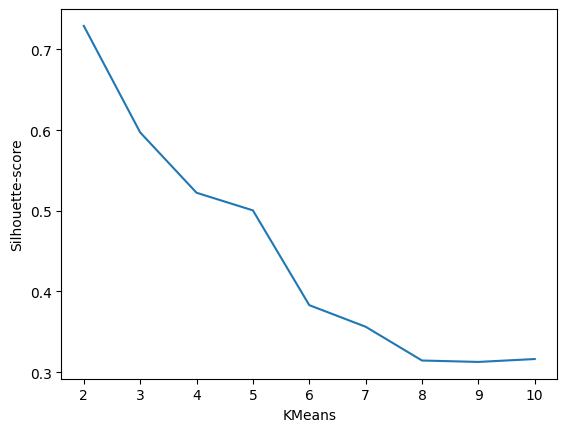

Best silhouette is obtained with k as:  2


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,cluster
14196,-117.03,32.71,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,0
8267,-118.16,33.77,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,0
17445,-120.48,34.66,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,0
14265,-117.11,32.69,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,0
2271,-119.80,36.78,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,1
...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,0
11964,-117.43,34.02,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,0
5390,-118.38,34.03,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,0
860,-121.96,37.58,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,1


In [207]:
pal.cluster()

## Apply steps to Test

In [235]:
pal.transformation_history[-1].get('pipeline')

ColumnTransformer(remainder='passthrough',
                  transformers=[('CT-0',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median'))]),
                                 ['latitude', 'longitude']),
                                ('CT-1',
                                 Pipeline(steps=[('1',
                                                  SimpleImputer(strategy='median')),
                                                 ('2', MinMaxScaler())]),
                                 ['households', 'housing_median_age',
                                  'median_house_value', 'median_income',
                                  'population', 'total_bedrooms',
                                  'total_rooms']),
                                ('CT-2', Pipeline(steps=[('3', OneHotter())]),
                                 ['ocean_proximity'])],
                  verbose_feature_names_out=False)

In [236]:
pal.output

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,-117.03,32.71,0.627451,0.079455,0.097145,0.064380,0.102286,0.190322,0.181445,0.0,0.0,0.0,0.0,1.0
8267,-118.16,33.77,0.941176,0.085966,0.121974,0.036744,0.124157,0.228452,0.756906,0.0,0.0,0.0,0.0,1.0
17445,-120.48,34.66,0.058824,0.048197,0.051210,0.025561,0.055090,0.252162,0.324949,0.0,0.0,0.0,0.0,1.0
14265,-117.11,32.69,0.686275,0.036090,0.056797,0.039659,0.058214,0.099488,0.161651,0.0,0.0,0.0,0.0,1.0
2271,-119.80,36.78,0.823529,0.060532,0.066729,0.024412,0.062325,0.210638,0.168043,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,0.666667,0.033776,0.031037,0.018358,0.035520,0.404829,0.441650,1.0,0.0,0.0,0.0,0.0
11964,-117.43,34.02,0.627451,0.078386,0.088299,0.049048,0.073672,0.175867,0.170723,0.0,1.0,0.0,0.0,0.0
5390,-118.38,34.03,0.686275,0.053385,0.088144,0.049133,0.086499,0.167894,0.427011,1.0,0.0,0.0,0.0,0.0
860,-121.96,37.58,0.274510,0.090874,0.092489,0.049721,0.091761,0.359947,0.553608,1.0,0.0,0.0,0.0,0.0


In [237]:
pal.execute_pipeline()

,latitude,longitude,households,housing_median_age,median_house_value,median_income,population,total_bedrooms,total_rooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
20046,36.06,-119.01,0.068826,0.470588,0.067424,0.081468,0.085888,0.077894,0.039519,0.0,1.0,0.0,0.0,0.0
3024,35.14,-119.46,0.112204,0.568627,0.063507,0.140095,0.096624,0.077894,0.077430,0.0,1.0,0.0,0.0,0.0
15663,37.80,-122.44,0.185271,1.000000,1.000000,0.205528,0.080799,0.077894,0.100815,0.0,0.0,0.0,1.0,0.0
20484,34.28,-118.72,0.095045,0.313725,0.419794,0.361216,0.105312,0.077894,0.080277,1.0,0.0,0.0,0.0,0.0
9814,36.62,-121.93,0.082128,0.647059,0.542268,0.222418,0.065471,0.077894,0.061823,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,33.36,-117.22,0.086755,0.294118,0.511959,0.283106,0.083344,0.087767,0.083283,1.0,0.0,0.0,0.0,0.0
16623,35.36,-120.83,0.135531,0.529412,0.519175,0.153563,0.101899,0.161638,0.113812,0.0,0.0,0.0,0.0,1.0
18086,37.31,-122.05,0.109119,0.470588,1.000000,0.602054,0.097865,0.098007,0.108223,1.0,0.0,0.0,0.0,0.0
2144,36.77,-119.76,0.090997,0.686275,0.118146,0.157591,0.075649,0.084842,0.065936,0.0,1.0,0.0,0.0,0.0


In [238]:
pal.transformed_test

,latitude,longitude,households,housing_median_age,median_house_value,median_income,population,total_bedrooms,total_rooms,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
20046,36.06,-119.01,0.068826,0.470588,0.067424,0.081468,0.085888,0.077894,0.039519,0.0,1.0,0.0,0.0,0.0
3024,35.14,-119.46,0.112204,0.568627,0.063507,0.140095,0.096624,0.077894,0.077430,0.0,1.0,0.0,0.0,0.0
15663,37.80,-122.44,0.185271,1.000000,1.000000,0.205528,0.080799,0.077894,0.100815,0.0,0.0,0.0,1.0,0.0
20484,34.28,-118.72,0.095045,0.313725,0.419794,0.361216,0.105312,0.077894,0.080277,1.0,0.0,0.0,0.0,0.0
9814,36.62,-121.93,0.082128,0.647059,0.542268,0.222418,0.065471,0.077894,0.061823,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,33.36,-117.22,0.086755,0.294118,0.511959,0.283106,0.083344,0.087767,0.083283,1.0,0.0,0.0,0.0,0.0
16623,35.36,-120.83,0.135531,0.529412,0.519175,0.153563,0.101899,0.161638,0.113812,0.0,0.0,0.0,0.0,1.0
18086,37.31,-122.05,0.109119,0.470588,1.000000,0.602054,0.097865,0.098007,0.108223,1.0,0.0,0.0,0.0,0.0
2144,36.77,-119.76,0.090997,0.686275,0.118146,0.157591,0.075649,0.084842,0.065936,0.0,1.0,0.0,0.0,0.0


_____

In [224]:
test = Pipeline([])

In [231]:
test.steps.append(('1',SimpleImputer()))

In [232]:
test

Pipeline(steps=[('1', SimpleImputer())])